# VolGAN-X — Stress Tests & Agentic Reinforcement

This notebook demonstrates how to:

1. Load a small dataset and build a dataloader
2. Initialize the Generator and AgenticReinforcer
3. Apply regime-specific stress nudges (high_vol, liquidity_shock, skew_twist, term_twist)
4. Visualize before/after surfaces

> Run this inside the repository so imports from `src/` work.

In [2]:
# 1) Imports
import sys, os, torch, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# Adjust path so we can import from src/
repo_src = '../src'  # if your notebook is at VolGAN-X/notebooks/, this is correct
sys.path.append(repo_src)

from generator import VolGenerator, VolGenConfig
from stress_module import AgenticReinforcer, ReinforceConfig, RegimeDetector

In [3]:
# 2) Data loading helper (minimal)
DATA_PATH = '../data/spx_options_sample.csv'
df = pd.read_csv(DATA_PATH).dropna(subset=['maturity','strike','implied_vol']).copy()

# Normalize inputs (T,K) to [0,1] for quick demonstration
T = torch.tensor(df['maturity'].values, dtype=torch.float32)
K = torch.tensor(df['strike'].values, dtype=torch.float32)
V = torch.tensor(df['implied_vol'].values, dtype=torch.float32)

def minmax(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

X = torch.stack([minmax(T), minmax(K)], dim=1)  # [N,2]
y = V.unsqueeze(1)                              # [N,1]

print('X shape:', X.shape, 'y shape:', y.shape)

X shape: torch.Size([9, 2]) y shape: torch.Size([9, 1])


In [4]:
# 3) Initialize Generator and Agentic module
G = VolGenerator(VolGenConfig(input_dim=2, fourier_features=16, hidden_dim=256, depth=5, bounded_head=True))
reinforcer = AgenticReinforcer(G, ReinforceConfig(strength=0.01), RegimeDetector())

# Build a grid for before/after comparison
Tg = torch.linspace(0.0, 1.0, 40)
Kg = torch.linspace(0.0, 1.0, 40)
pts_before, vols_before = G.sample_grid(Tg, Kg)  # untrained / initial params

In [5]:
# 4) Apply regime-specific stress tests
# You can iterate multiple times to accentuate the effect

regimes = ['high_vol', 'liquidity_shock', 'skew_twist', 'term_twist']
for r in regimes:
    _ = reinforcer.detector.detect(X, y)  # detection (not strictly necessary for manual mode)
    # Directly call a matching nudge via decide_and_apply using (X, y)
    reinforcer.decide_and_apply(X, y)
    print('Applied agentic nudge for regime:', r)

Applied agentic nudge for regime: high_vol
Applied agentic nudge for regime: liquidity_shock
Applied agentic nudge for regime: skew_twist
Applied agentic nudge for regime: term_twist


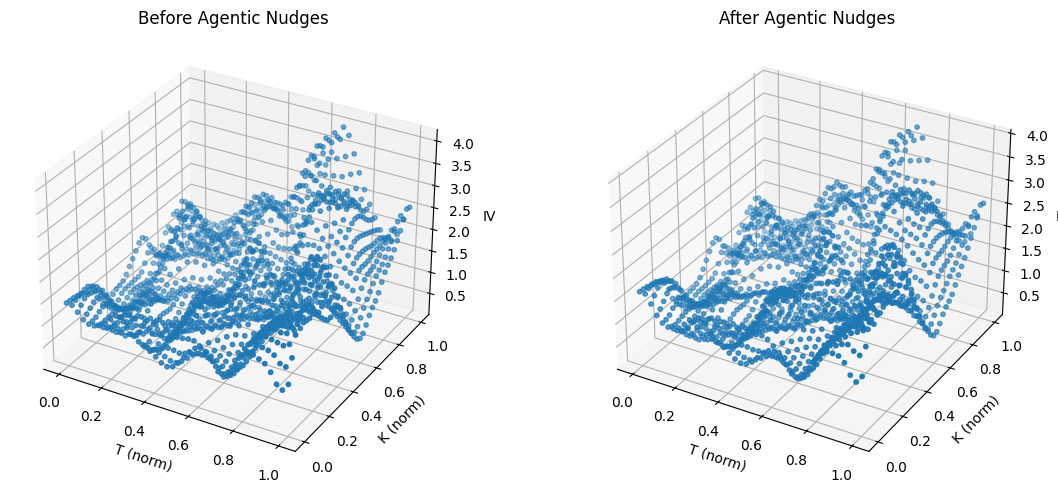

In [6]:
# 5) After-nudge grid
pts_after, vols_after = G.sample_grid(Tg, Kg)

# 3D scatter compare (before/after)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pts_before.numpy()[:,0], pts_before.numpy()[:,1], vols_before.numpy().squeeze(), s=10)
ax1.set_title('Before Agentic Nudges')
ax1.set_xlabel('T (norm)'); ax1.set_ylabel('K (norm)'); ax1.set_zlabel('IV')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(pts_after.numpy()[:,0], pts_after.numpy()[:,1], vols_after.numpy().squeeze(), s=10)
ax2.set_title('After Agentic Nudges')
ax2.set_xlabel('T (norm)'); ax2.set_ylabel('K (norm)'); ax2.set_zlabel('IV')

plt.tight_layout()
plt.show()

> **Note:** The generator is untrained in this quick demo. For meaningful changes, train with `src/main.py` and then re-run this notebook to observe regime-adaptive behavior.